# Sentiment Analysis for Financial News

In [2]:
import pandas as pd
import numpy as np

# graphs
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_theme()
sns.set_context("paper")

# cleaning
import unidecode

# stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# vocab
from collections import Counter

# models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm  
import skorch as NeuralNetClassifier


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Camille\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preprocessing

Loading the dataset.

In [3]:
data = pd.read_csv('data.csv', encoding='latin-1', names=['sentiment','text'])

In [4]:
data.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


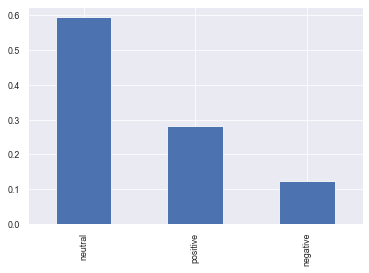

In [5]:
(data.sentiment.value_counts() / data.shape[0]).plot.bar();

Cleaning the text.

In [6]:
# Removing punctuation and special caracters
data['text'] = data['text'].str.replace('[^\w\s]', '', regex=True)
data['text'] = data['text'].str.replace('_', ' ')
data['text'] = data['text'].astype('unicode')
data['text'] = data['text'].transform(lambda x: unidecode.unidecode(x))

# Lowercase the text
data['text'] = data['text'].str.lower()

# Removing numbers
data['text'] = data['text'].str.replace('\d+', '', regex=True)

# Removing stop words
nltk_stopwords = stopwords.words('english')
data['text'] = data['text'].apply(lambda x: [item for item in x.split() if item not in nltk_stopwords])

# Lemmatization and/or Expand Contractions ?

Split train and test set

In [7]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=1)
# test_set, validation_set = train_test_split(test_set, test_size=0.5, random_state=2)

Building the vocabulary from the training set

In [8]:
# extract all the words and count them
vocab = Counter([word for sentence in train_set['text'].values.tolist() for word in sentence])

print('Number of words in the training set : ' + str(sum(vocab.values())))
print('Number of unique words in the training set : ' + str(len(list(vocab))))

# Sort the words
vocab = vocab.most_common()

print('Most frequent words : ' + str(vocab[0:10]))

# convert the vocabulary to a Python Dict
vocab = dict(vocab)

# encode words as integers
sparse_vocab = {word:i for i, word in enumerate(vocab, 1)} 
inv_sparse_vocab = {v: k for k, v in sparse_vocab.items()}

Number of words in the training set : 46400
Number of unique words in the training set : 8337
Most frequent words : [('eur', 1057), ('company', 680), ('mn', 475), ('said', 437), ('finnish', 405), ('sales', 354), ('million', 335), ('profit', 325), ('net', 323), ('finland', 278)]


Distribution of the length of the sentences

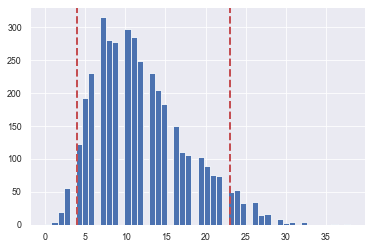

In [9]:
length = train_set['text'].apply(lambda sentence : len(sentence))
limit_low, limit_high  = length.quantile(q=[0.05, 0.95]).values
length.hist(bins=50);
plt.axvline(limit_low, color='r', linewidth=2, linestyle="dashed");
plt.axvline(limit_high, color='r', linewidth=2, linestyle="dashed");

Encode the text and labels

In [60]:
def encode_text(data, limit_low = limit_low, limit_high = limit_high):
    # encode sentences and set -1 if the word is not in the vocabulary
    data['text_encoded'] = data['text'].apply(
        lambda sentence : [sparse_vocab.get(word, 0) for word in sentence]
    )

    # drop sentences that are extremely short or long
    data['length'] = data['text_encoded'].apply(lambda sentence : len(sentence))
    data = data[(data['length'] <= limit_high) & (data['length'] >= limit_low)].copy()

    # pad sentences so that each vector has the same length
    max_len = int(limit_high)
    data['text_encoded'] = data.apply(lambda row: [0] * (max_len - row['length']) + row['text_encoded'], axis=1)
    data['length'] = data['text_encoded'].apply(lambda sentence : len(sentence))

    if sum(data['length'] != max_len):
        print('WARNING')

    return data

def decode(data):
    for encoded_sentence in data:
        print([inv_sparse_vocab.get(number, '') for number in encoded_sentence])

Store the encoded data as Tensors.

In [61]:
def format_tensors(set):
    txt = encode_text(set.copy())
    labels = txt['sentiment'].replace(['positive','neutral','negative'], [0, 1, 2])

    return torch.tensor(np.vstack(txt['text_encoded'])), torch.tensor(np.vstack(labels)).long()

train_txt, train_labels = format_tensors(train_set)
# val_txt, val_labels = format_tensors(validation_set)
test_txt, test_labels = format_tensors(test_set)

# validation_dataloader = DataLoader(
#     TensorDataset(val_txt, val_labels), 
#     batch_size = len(val_labels)
# )

test_dataloader = DataLoader(
    TensorDataset(test_txt, test_labels), 
    batch_size = len(test_labels)
)

## Supervised learning

### A first naive model

In [32]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


Initialize a RNN module with Pytorch.

In [85]:
class RNN_module(nn.Module):

    def __init__(self, vocab_dim, embedding_dim, hidden_dim):
        super().__init__()

        # embedding layer
        self.embedding = nn.Embedding(vocab_dim, embedding_dim)
        # RNN layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        # fully connected layer
        self.fc = nn.Linear(hidden_dim, 3)

    def forward(self, txt):
        emb_txt = self.embedding(txt.T)
        rnn_out, rnn_hidden = self.rnn(emb_txt)
        fc_out = self.fc(rnn_hidden.squeeze(0))
        return fc_out

Wrap the RNN module with Skorch.

In [102]:
rnn_net = NeuralNetClassifier(
    RNN_module,
    criterion = nn.CrossEntropyLoss(),
    optimizer = torch.optim.SGD,
    device = device,
    module__vocab_dim = len(vocab) + 1,
    module__embedding_dim = 50,
    module__hidden_dim = 32
)

In [103]:
rnn_net.initialize()

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=RNN_module(
    (embedding): Embedding(8338, 50)
    (rnn): RNN(50, 32)
    (fc): Linear(in_features=32, out_features=3, bias=True)
  ),
)

Finetune the hyperparameters with GridSearch

In [105]:
param_grid = {
    'batch_size' : [16, 32],
    'max_epochs' : [10, 50, 100],
    'lr' : [1e-2, 1e-3],
    'module__embedding_dim' : [10, 50, 100],
    'module__hidden_dim' : [10, 50, 100]
}

grid = GridSearchCV(
    estimator=rnn_net, 
    param_grid=param_grid,
    n_jobs=-1,
)

cross_validation = grid.fit(train_txt, train_labels.squeeze())

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0901       0.4524        1.0709  2.0725
      2        1.0497       0.5214        1.0367  1.6466
      3        1.0185       0.5503        1.0103  2.2328
      4        0.9940       0.5766        0.9898  1.8941
      5        0.9745       0.5848        0.9735  1.8752
      6        0.9588       0.5917        0.9606  2.1223
      7        0.9460       0.5917        0.9503  1.6498
      8        0.9355       0.5917        0.9418  1.6693
      9        0.9266       0.5945        0.9348  1.6167
     10        0.9192       0.6000        0.9290  1.6187
     11        0.9127       0.6028        0.9240  1.9018
     12        0.9071       0.6028        0.9196  1.9933
     13        0.9021       0.6055        0.9158  1.6965
     14        0.8976       0.6055        0.9124  1.6657
     15        0.8936       0.6041        0.9093  1.6745
     16        0.8898       0.6

In [106]:
print("Best: %f using %s" % (cross_validation.best_score_, cross_validation.best_params_))
means = cross_validation.cv_results_['mean_test_score']
stds = cross_validation.cv_results_['std_test_score']
params = cross_validation.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.627862 using {'batch_size': 16, 'lr': 0.001, 'max_epochs': 50, 'module__embedding_dim': 50, 'module__hidden_dim': 100}
0.597241 (0.005720) with: {'batch_size': 16, 'lr': 0.01, 'max_epochs': 10, 'module__embedding_dim': 10, 'module__hidden_dim': 10}
0.606621 (0.014993) with: {'batch_size': 16, 'lr': 0.01, 'max_epochs': 10, 'module__embedding_dim': 10, 'module__hidden_dim': 50}
0.610483 (0.012417) with: {'batch_size': 16, 'lr': 0.01, 'max_epochs': 10, 'module__embedding_dim': 10, 'module__hidden_dim': 100}
0.599172 (0.008793) with: {'batch_size': 16, 'lr': 0.01, 'max_epochs': 10, 'module__embedding_dim': 50, 'module__hidden_dim': 10}
0.626483 (0.010373) with: {'batch_size': 16, 'lr': 0.01, 'max_epochs': 10, 'module__embedding_dim': 50, 'module__hidden_dim': 50}
0.618207 (0.009730) with: {'batch_size': 16, 'lr': 0.01, 'max_epochs': 10, 'module__embedding_dim': 50, 'module__hidden_dim': 100}
0.605517 (0.004184) with: {'batch_size': 16, 'lr': 0.01, 'max_epochs': 10, 'module__embeddi

Train and evaluate the model without Skorch

In [83]:
def train_epoch(dataloader, model, optimizer, loss_function):
    
    model.train()
    
    for txt, label in dataloader:

        # txt, label = txt.to(device), label.to(device)

        # forward computation
        pred = model(txt)
        loss = loss_function(pred, label.squeeze())

        # backward computation
        optimizer.zero_grad()  
        loss.backward()
        optimizer.step()

In [84]:
def eval_epoch(dataset, model, loss_function, accuracy_function):
    
    model.eval()
    loss = []
    acc = []
    
    with torch.no_grad():

        for txt, label in dataset:

            # txt, label = txt.to(device), label.to(device)

            pred = model(txt)
            loss.append(loss_function(pred, label.squeeze()).item())
            acc.append(accuracy_function(pred, label).item())
        
    return np.mean(loss), np.mean(acc)

In [86]:
def train_and_validate_RNN(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE, verbose = False):
    
    train_dataloader = DataLoader(
        TensorDataset(train_txt, train_labels), 
        batch_size = BATCH_SIZE,
        shuffle = True
    )

    model = RNN_module(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM)

    loss_function = nn.CrossEntropyLoss()
    accuracy_function = lambda pred, target : torch.sum((torch.argmax(torch.softmax(pred, dim=1), dim=1) == target.T)) / len(target)
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

    train_loss_array = []
    train_accuracy_array = []
    val_loss_array = []
    val_accuracy_array = []

    for epoch in tqdm(range(EPOCHS)):
        # training
        train_epoch(train_dataloader, model, optimizer, loss_function)

        # compute loss and accuracy metrics
        train_loss, train_accuracy = eval_epoch(train_dataloader, model, loss_function, accuracy_function)
        val_loss, val_accuracy = eval_epoch(test_dataloader, model, loss_function, accuracy_function)

        train_loss_array.append(train_loss)
        train_accuracy_array.append(train_accuracy)
        val_loss_array.append(val_loss)
        val_accuracy_array.append(val_accuracy)

        if verbose:
            print('EPOCH : ' + str(epoch + 1))
            print('Training loss : ' + str(train_loss) + ' | Training accuracy : ' + str(train_accuracy))
            print('Validation loss : ' + str(val_loss) + ' | Validation accuracy : ' + str(val_accuracy))

    fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout = True, figsize = (10,10))

    sns.lineplot(x=range(EPOCHS), y=train_loss_array, ax=ax1, label='Training set')
    sns.lineplot(x=range(EPOCHS), y=val_loss_array, ax=ax1, label='Validation set')
    ax1.set_xlabel('Epochs')
    ax1.set_title('Loss')
    ax1.legend();

    sns.lineplot(x=range(EPOCHS), y=train_accuracy_array, ax=ax2, label='Training set')
    sns.lineplot(x=range(EPOCHS), y=val_accuracy_array, ax=ax2, label='Validation set')
    ax2.set_xlabel('Epochs')
    ax2.set_title('Accuracy')
    ax2.legend();

    fig.suptitle('RNN | Batch size : ' + str(BATCH_SIZE) + ' | Embedding : ' + str(EMBEDDING_DIM) + ' | Hidden : ' + str(HIDDEN_DIM) + ' | Rate : ' + str(LEARNING_RATE));

    return model

100%|██████████| 50/50 [01:09<00:00,  1.40s/it]


RNN_module(
  (embedding): Embedding(8338, 50)
  (rnn): RNN(50, 32)
  (fc): Linear(in_features=32, out_features=3, bias=True)
)

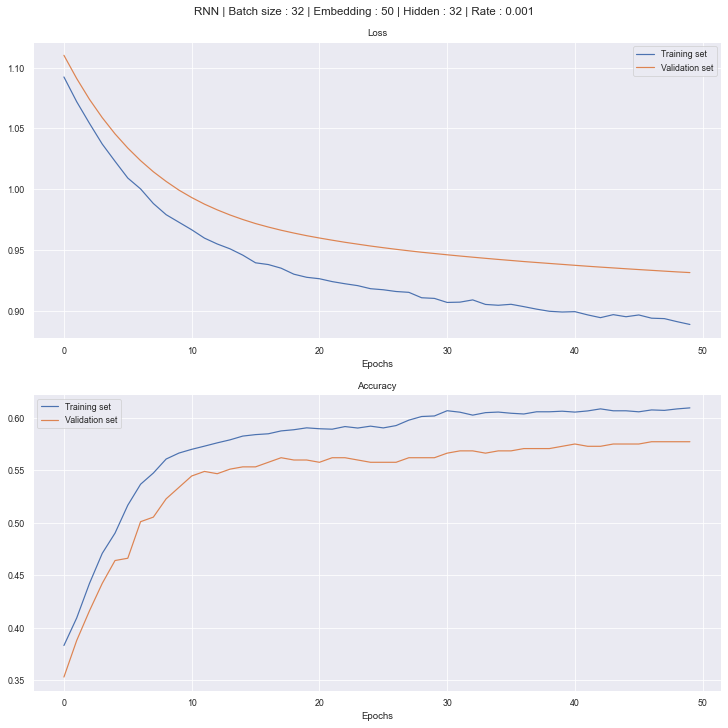

In [87]:
VOCAB_DIM = len(vocab) + 1
EMBEDDING_DIM = 50
HIDDEN_DIM = 32
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 32

train_and_validate_RNN(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE)

100%|██████████| 50/50 [00:37<00:00,  1.34it/s]


(RNN_model(
   (embedding): Embedding(8338, 50)
   (rnn): RNN(50, 64)
   (fc): Linear(in_features=64, out_features=3, bias=True)
 ),
 (0.8806644678115845, 0.6137787103652954))

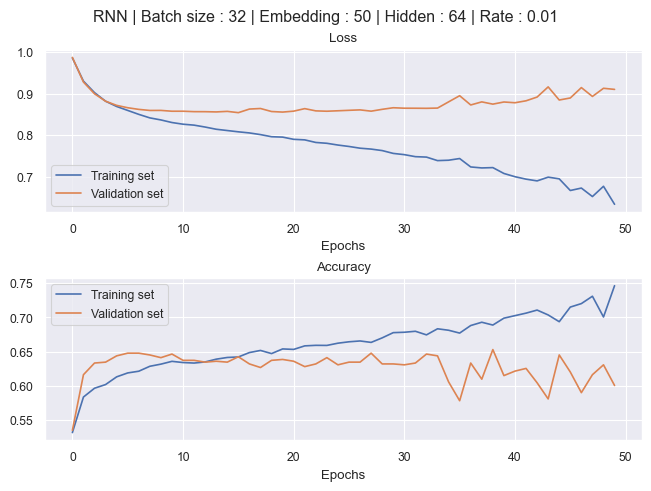

In [846]:
VOCAB_DIM = len(vocab) + 1
EMBEDDING_DIM = 50
HIDDEN_DIM = 64
LEARNING_RATE = 1e-2
EPOCHS = 50
BATCH_SIZE = 32

train_and_validate_RNN(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE)

100%|██████████| 50/50 [00:31<00:00,  1.59it/s]


(RNN_model(
   (embedding): Embedding(8338, 50)
   (rnn): RNN(50, 32)
   (fc): Linear(in_features=32, out_features=3, bias=True)
 ),
 (0.9262232184410095, 0.612734854221344))

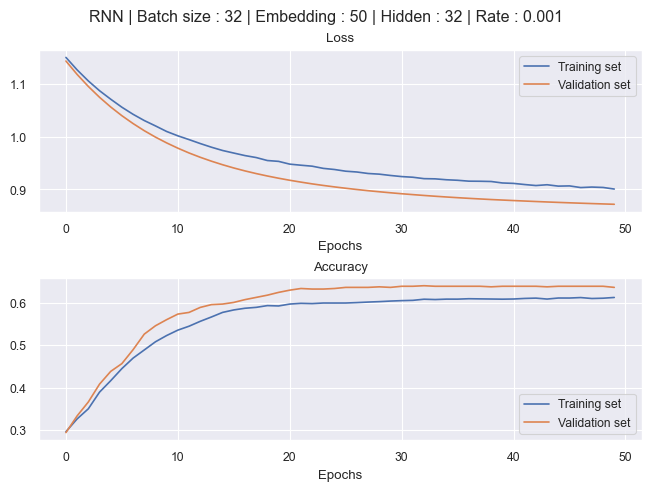

In [847]:
VOCAB_DIM = len(vocab) + 1
EMBEDDING_DIM = 50
HIDDEN_DIM = 32
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 32

train_and_validate_RNN(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE)

100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


(RNN_model(
   (embedding): Embedding(8338, 100)
   (rnn): RNN(100, 64)
   (fc): Linear(in_features=64, out_features=3, bias=True)
 ),
 (0.9043315052986145, 0.6210855841636658))

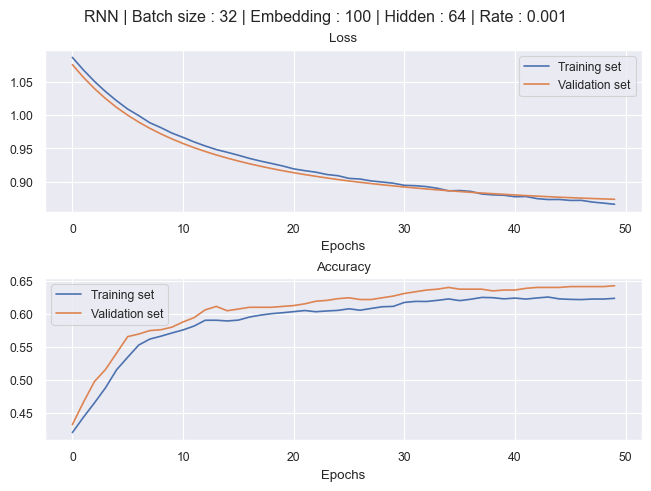

In [848]:
VOCAB_DIM = len(vocab) + 1
EMBEDDING_DIM = 100
HIDDEN_DIM = 64
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 32

train_and_validate_RNN(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE)

100%|██████████| 50/50 [00:37<00:00,  1.32it/s]


(RNN_model(
   (embedding): Embedding(8338, 100)
   (rnn): RNN(100, 128)
   (fc): Linear(in_features=128, out_features=3, bias=True)
 ),
 (0.9229958653450012, 0.6033402681350708))

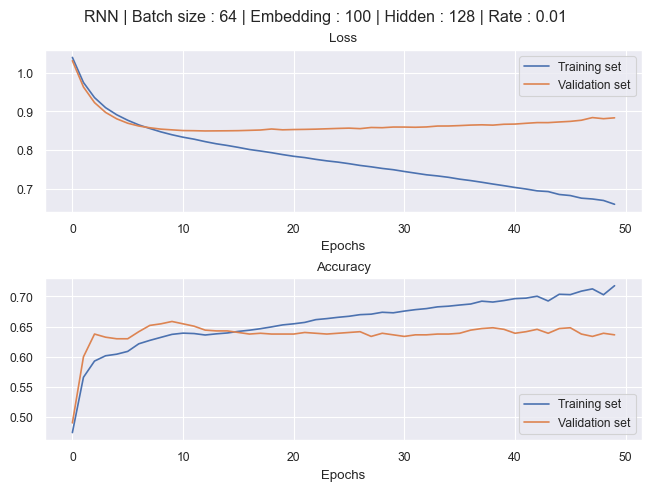

In [849]:
VOCAB_DIM = len(vocab) + 1
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
LEARNING_RATE = 1e-2
EPOCHS = 50
BATCH_SIZE = 64

train_and_validate_RNN(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE)

In [18]:
import numpy as np
from sklearn.datasets import make_classification
from torch import nn

from skorch import NeuralNetClassifier


X, y = make_classification(1000, 20, n_informative=10, random_state=0)
X = X.astype(np.float32)
y = y.astype(np.int64)



# net.fit(X, y)
# y_proba = net.predict_proba(X)